In [ ]:
!pip uninstall -y numpy

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2


In [ ]:
!pip install --no-cache-dir numpy==1.26.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 235.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.3 which is incompatible.


In [ ]:
import os
os.kill(os.getpid(), 9)

In [ ]:
import numpy
numpy.__version__



'1.26.3'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
save_path_videos = '/content/drive/MyDrive/paths/dataset_Videos.npy'
save_path_labels = '/content/drive/MyDrive/paths/dataset_labels.npy'

In [ ]:
import numpy as np

videos = np.load(save_path_videos)
labels = np.load(save_path_labels)

In [ ]:
# Print the shape of the videos and labels arrays
print("Videos shape:", videos.shape)
print("Labels shape:", labels.shape)

Videos shape: (4050, 22, 80, 112, 1)
Labels shape: (4050,)


In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Encode the labels into numerical values
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# One-hot encode the labels
labels_onehot = to_categorical(labels_encoded)

# Display the mapping
print("✅ Label encoding mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{i} → {label}")

print("✅ Labels encoded and one-hot encoded.")


✅ Label encoding mapping:
0 → a
1 → bye
2 → can
3 → cat
4 → demo
5 → dog
6 → hello
7 → here
8 → is
9 → lips
10 → my
11 → read
12 → you
✅ Labels encoded and one-hot encoded.


In [ ]:
label_dict = {0:"a", 1: "bye", 2:"can", 3:"cat", 4:"demo", 5:"dog", 6: "hello", 7:"here", 8:"is", 9:"lips", 10:"my", 11:"read", 12:"you"}

In [ ]:
from sklearn.model_selection import train_test_split

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    videos, labels_onehot, test_size=0.2, random_state=42, stratify=labels_encoded
)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")


Training set: (3240, 22, 80, 112, 1), (3240, 13)
Validation set: (810, 22, 80, 112, 1), (810, 13)


In [ ]:
import gc
gc.collect()
!cat /proc/meminfo | grep Mem


MemTotal:       13289424 kB
MemFree:          137308 kB
MemAvailable:    5388924 kB


In [ ]:
del videos
del labels
del labels_encoded
del labels_onehot

In [ ]:
# =============================================================================
# 5. Residual 3D Network (R3D-Lite) - Fixed Version
# =============================================================================
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
import numpy as np
from tensorflow.keras.optimizers import Adam

class Residual3DBlock(layers.Layer):
    """3D Residual block for video processing"""

    def __init__(self, filters, kernel_size=(3, 3, 3), strides=(1, 1, 1), **kwargs):
        super(Residual3DBlock, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides

        # Main path
        self.conv1 = layers.Conv3D(
            filters, kernel_size, strides=strides, padding='same', activation='relu'
        )
        self.bn1 = layers.BatchNormalization()

        self.conv2 = layers.Conv3D(
            filters, kernel_size, padding='same'
        )
        self.bn2 = layers.BatchNormalization()

        # Shortcut path (if dimensions change)
        self.shortcut_conv = None
        self.shortcut_bn = None

    def build(self, input_shape):
        super(Residual3DBlock, self).build(input_shape)
        # Add shortcut conv if needed
        if (input_shape[-1] != self.filters or
            any(s != 1 for s in self.strides)):
            self.shortcut_conv = layers.Conv3D(
                self.filters, (1, 1, 1), strides=self.strides, padding='same'
            )
            self.shortcut_bn = layers.BatchNormalization()

    def call(self, inputs, training=None):
        # Main path
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)

        x = self.conv2(x)
        x = self.bn2(x, training=training)

        # Shortcut path
        if self.shortcut_conv:
            shortcut = self.shortcut_conv(inputs)
            shortcut = self.shortcut_bn(shortcut, training=training)
        else:
            shortcut = inputs

        # Add and activate
        x = x + shortcut
        return tf.nn.relu(x)

class TransposeLayer(layers.Layer):
    """Custom layer to handle transpose operation in functional API"""

    def __init__(self, perm, **kwargs):
        super(TransposeLayer, self).__init__(**kwargs)
        self.perm = perm

    def call(self, inputs):
        return tf.transpose(inputs, self.perm)

    def get_config(self):
        config = super(TransposeLayer, self).get_config()
        config.update({'perm': self.perm})
        return config

def create_r3d_lite_model(input_shape=(22, 80, 112, 1), num_classes=13):
    """
    Lightweight Residual 3D Network for lip reading

    Args:
        input_shape: (sequence_length, height, width, channels)
        num_classes: Number of output classes
    """
    inputs = layers.Input(shape=input_shape)

    # The input is already in the correct format for 3D convolution
    # (batch, sequence_length, height, width, channels)
    # For 3D convolution, we need (batch, depth, height, width, channels)
    # Since sequence_length represents the temporal dimension (depth), no transpose needed
    x = inputs

    # Initial 3D convolution
    x = layers.Conv3D(32, (3, 3, 3), strides=(1, 2, 2), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling3D((1, 2, 2), strides=(1, 2, 2))(x)

    # Residual blocks
    x = Residual3DBlock(64, strides=(1, 1, 1))(x)
    x = Residual3DBlock(64)(x)

    x = Residual3DBlock(128, strides=(2, 2, 2))(x)
    x = Residual3DBlock(128)(x)

    x = Residual3DBlock(256, strides=(2, 1, 1))(x)
    x = Residual3DBlock(256)(x)

    # Global average pooling
    x = layers.GlobalAveragePooling3D()(x)

    # Classification head
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs, name='R3D_Lite')
    return model

# Example usage
print("=== Residual 3D Network (R3D-Lite) ===")
r3d_model = create_r3d_lite_model(input_shape=(22, 80, 112, 1), num_classes=13)
r3d_model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
r3d_model.summary()
print()

=== Residual 3D Network (R3D-Lite) ===


Model: "R3D_Lite"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 22, 80, 112, 1) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 22, 40, 56, 32) │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 22, 40, 56, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 22, 20, 28, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual3d_block                │ (None, 22, 20, 28, 64) │       168,896 │
│ (Residual3DBlock)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual3d_block_1              │ (None, 22, 20, 28, 64) │       221,824 │
│ (Residual3DBlock)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual3d_block_2              │ (None, 11, 10, 14,     │       673,664 │
│ (Residual3DBlock)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual3d_block_3              │ (None, 11, 10, 14,     │       886,016 │
│ (Residual3DBlock)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual3d_block_4              │ (None, 6, 10, 14, 256) │     2,690,816 │
│ (Residual3DBlock)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual3d_block_5              │ (None, 6, 10, 14, 256) │     3,541,504 │
│ (Residual3DBlock)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 13)             │         3,341 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,449,997 (32.23 MB)

 Trainable params: 8,445,453 (32.22 MB)

 Non-trainable params: 4,544 (17.75 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks for better training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.5)
]

history = r3d_model.fit(X_train, y_train,
             validation_data=(X_val, y_val),
             epochs=80,
             batch_size=8,
             callbacks=callbacks)

Epoch 1/80
405/405 ━━━━━━━━━━━━━━━━━━━━ 135s 268ms/step - accuracy: 0.0838 - loss: 2.8133 - val_accuracy: 0.1037 - val_loss: 2.6808 - learning_rate: 1.0000e-04
Epoch 2/80
405/405 ━━━━━━━━━━━━━━━━━━━━ 95s 234ms/step - accuracy: 0.0854 - loss: 2.6134 - val_accuracy: 0.0963 - val_loss: 2.5348 - learning_rate: 1.0000e-04
Epoch 3/80
405/405 ━━━━━━━━━━━━━━━━━━━━ 94s 233ms/step - accuracy: 0.1182 - loss: 2.5127 - val_accuracy: 0.1741 - val_loss: 2.3502 - learning_rate: 1.0000e-04
Epoch 4/80
405/405 ━━━━━━━━━━━━━━━━━━━━ 96s 237ms/step - accuracy: 0.2075 - loss: 2.2601 - val_accuracy: 0.4160 - val_loss: 1.7176 - learning_rate: 1.0000e-04
Epoch 5/80
405/405 ━━━━━━━━━━━━━━━━━━━━ 96s 237ms/step - accuracy: 0.3726 - loss: 1.8128 - val_accuracy: 0.5716 - val_loss: 1.3322 - learning_rate: 1.0000e-04
Epoch 6/80
405/405 ━━━━━━━━━━━━━━━━━━━━ 142s 237ms/step - accuracy: 0.4788 - loss: 1.4869 - val_accuracy: 0.5852 - val_loss: 1.2059 - learning_rate: 1.0000e-04
Epoch 7/80
405/405 ━━━━━━━━━━━━━━━━━━━━ 142s

In [ ]:
def evaluate_model(model, name="Model"):
    loss, acc = model.evaluate(X_val, y_val, verbose=0)
    print(f"{name} - Validation Accuracy: {acc:.4f}, Loss: {loss:.4f}")

evaluate_model(r3d_model, "Residual 3D Network ")



Residual 3D Network  - Validation Accuracy: 0.9259, Loss: 0.2674


In [ ]:
# Save the trained model
r3d_model.save("/content/drive/MyDrive/models/r3d.h5")
print("✅ Model saved.")


✅ Model saved.


In [ ]:
y_pred_prob = r3d_model.predict(X_val)
y_pred = np.argmax(y_pred_prob, axis=1)

26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 303ms/step


In [ ]:
from prettytable import PrettyTable
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical

# Convert y_pred to one-hot encoded format to match y_val
y_pred_onehot = to_categorical(y_pred, num_classes=y_val.shape[1])

# Generate classification report
report = classification_report(y_val, y_pred_onehot, output_dict=True)

table = PrettyTable()
table.field_names = ["Class", "Precision", "Recall", "F1-Score", "Support"]
for label, metrics in report.items():
    if label.isdigit():
        precision = round(metrics['precision'], 2)
        recall = round(metrics['recall'], 2)
        f1_score = round(metrics['f1-score'], 2)
        support = metrics['support']
        table.add_row([label_dict[int(label)], precision, recall, f1_score, support])

print(table)

+-------+-----------+--------+----------+---------+
| Class | Precision | Recall | F1-Score | Support |
+-------+-----------+--------+----------+---------+
|   a   |    0.91   |  0.81  |   0.86   |   64.0  |
|  bye  |    0.8    |  0.89  |   0.84   |   62.0  |
|  can  |    0.89   |  0.9   |   0.89   |   61.0  |
|  cat  |    0.91   |  0.85  |   0.88   |   59.0  |
|  demo |    1.0    |  0.95  |   0.98   |   62.0  |
|  dog  |    0.98   |  0.98  |   0.98   |   60.0  |
| hello |    0.96   |  0.95  |   0.96   |   57.0  |
|  here |    0.93   |  0.97  |   0.95   |   66.0  |
|   is  |    0.89   |  0.97  |   0.93   |   65.0  |
|  lips |    0.97   |  0.98  |   0.98   |   64.0  |
|   my  |    0.95   |  0.83  |   0.88   |   64.0  |
|  read |    0.93   |  0.95  |   0.94   |   65.0  |
|  you  |    0.95   |  1.0   |   0.98   |   61.0  |
+-------+-----------+--------+----------+---------+


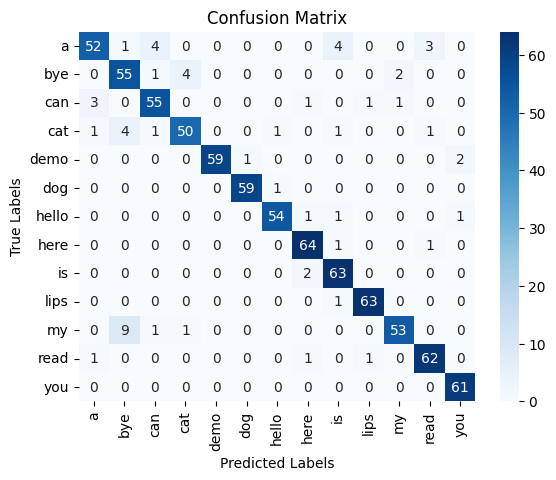

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

# Convert y_val to multiclass format
y_val_multiclass = np.argmax(y_val, axis=1)  # Convert one-hot to class indices

# Now generate the confusion matrix
conf_matrix = sklearn.metrics.confusion_matrix(y_val_multiclass, y_pred)

# Define the list of label strings in the order of their integer values
label_strings = [label_dict[i] for i in range(len(label_dict))]

# Generate the heatmap confusion matrix
sns.heatmap(conf_matrix, annot=True, cmap="Blues", xticklabels=label_strings, yticklabels=label_strings)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

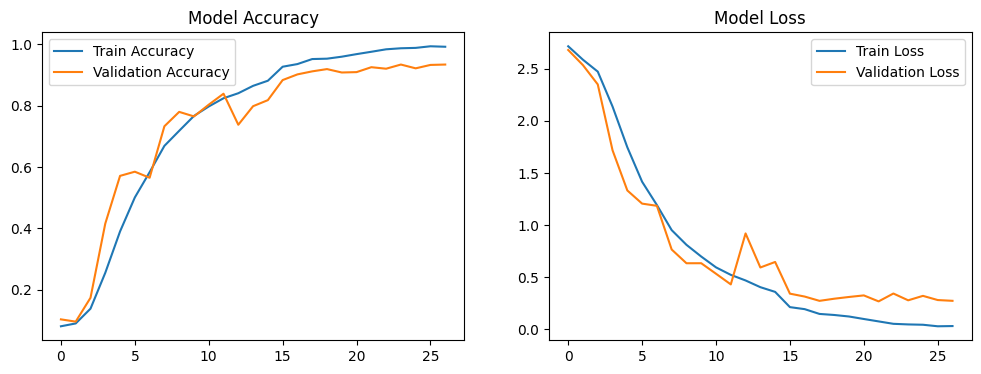

In [ ]:
import matplotlib.pyplot as plt
# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Model Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Model Loss')
    plt.show()

plot_training_history(history)
